# Package loading and basic configurations

In [3]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
from scipy.misc import derivative
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [4]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox,  num_results=50) # requesting 50 tracks inside the bbox



In [5]:
one_track_id = track_df['track.id'].unique()[2]
one_track = track_df[track_df['track.id'] == one_track_id]


## Add elevation

In [ ]:
import requests as req
url = 'https://api.opentopodata.org/v1/eudem25m?locations='
def get_elvdata(lat,lng):
    access = url+str(lat)+(',')+str(lng)
    elevation = req.request('GET',access)
    data = eval(elevation.text)
    #print(data) # debug code for everyone to check the request status
    return data['results'][0]['elevation']
for i in one_track.index:     
    one_track.loc[i,'elevation'] = get_elvdata(one_track.loc[i,'geometry'].y,one_track.loc[i,'geometry'].x)
#The request takes time
one_track

## Calculate gradient(Elevation) & add time interval

In [255]:
def distance(lon1,lon2,lat1,lat2):
    R = 6370000 #radius
    φ1=lat1 * np.pi /180
    φ2 = lat2 * np.pi /180
    Δφ = (lat2-lat1) * np.pi /180
    Δλ = (lon2-lon1) * np.pi /180
    a = np.sin(Δφ/2) * np.sin(Δφ/2) +np.cos(φ1) * np.cos(φ2) *np.sin(Δλ/2) * np.sin(Δλ/2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a));
    return R * c
def gradient(height,distance):
    return np.arctan(height/distance) * 180/np.pi

for i in one_track.index:
    if (i == len(one_track)-1):
        break
    lat1= one_track.loc[i,'geometry'].y
    lat2= one_track.loc[i+1,'geometry'].y
    lon1= one_track.loc[i,'geometry'].x
    lon2= one_track.loc[i+1,'geometry'].x
    heightdiff = one_track.loc[i+1,'elevation'] - one_track.loc[i,'elevation']
    one_track.loc[i+1,'seg_distance']= distance(lon1,lon2,lat1,lat2)
    
    one_track.loc[i,'gradient']= gradient(heightdiff,one_track.loc[i+1,'seg_distance'])

## Add interval time
j = 5
for i in one_track.index:
    one_track.loc[i, 'time_interval'] = j
    j = j+5

# Convert the speed unit to m/s
for i in one_track.index:
    one_track.loc[i, 'speed'] = one_track.loc[i, 'GPS Speed.value'] * 0.27777

## Getting the velocity equation & Calculate the acceleration

In [258]:

## get the speed equation
time_interval = np.array(one_track['time_interval'])
speed = np.array(one_track['speed'])
idx = np.isfinite(time_interval) & np.isfinite(speed)

def get_equation(x,y):
    degree = 80
    coefs, res, _, _, _ = np.polyfit(x,y,degree, full = True)
    ffit = np.poly1d(coefs)
    #print (ffit)
    return ffit

speed_equation = get_equation(time_interval[idx], speed[idx])

    
## calculate the acceleration using the derivative

for i in one_track.index:
    if one_track.loc[i, 'speed'] == 0:
        one_track.loc[i, 'Acceleration'] = 0
    else:
        one_track.loc[i, 'Acceleration'] = derivative(speed_equation, one_track.loc[i, 'time_interval'])




## Filter the data

In [283]:
realistc_drive = one_track[['speed', 'time', 'time_interval', 'Acceleration', 'gradient']]


## Define General Parameters 

In [267]:
P_air = 1.2   # Air mass density "kg per m³" 
P_idle = 2    # Idle power "kW"
Cw = 0.3      # Air drag cofficient 
H_g = 8.8     # Calorific value gasoline "kWh/l"
H_d = 9.9     # Calorific value diesel "kWh/l"
g = 9.81      # Gravitational acceleration "m/s²"
efc = 0.30    # efficiency constant value from Literature 0.25 - 0.35

##  Define Parameters for vehicle

In [268]:
# m = mass of the car  "kg" 
# A = cross-sectional of the car "m²"
# Cw = Air drag cofficient 
class Car:
    def __init__(self,m=1500,A=2,Cw=0.3):
        self.m = m
        self.A = A
        self.Cw = Cw

##  Define specific paramerer by class (Volkswagen)
volks = Car(1570,2.179,0.32)
##generalcar = car
car = Car()


## Define fuel consumption

In [269]:
def fuel_consumption(eng_pow, H_fuel, efc):
    consumption = eng_pow / (H_fuel * efc)
    return consumption

## Define engine power (KW)
def engine_power(car,Cr,gradient,speed,acceleration):
    if speed > 0:
        power =speed*(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance)
        return [power/1000]
    else:
        return [P_idle,0]

## Engine Power

In [279]:
## Calculates Engine Power for general car
for i in realistc_drive.index:
    ep = engine_power(car,0.02,realistc_drive.gradient[i],realistc_drive.speed[i],realistc_drive.Acceleration[i])
    if ep[0] < 0:
        realistc_drive.loc[i, 'engine_power'] = P_idle
    else:
        realistc_drive.loc[i, 'engine_power'] = ep[0]
        
#Calculates Engine Power for Volks
for i in realistc_drive.index:
    ep = engine_power(volks,0.02,realistc_drive.gradient[i],realistc_drive.speed[i],realistc_drive.Acceleration[i])
    if ep[0] < 0:
        realistc_drive.loc[i, 'eng_pw_volks'] = P_idle
    else:
        realistc_drive.loc[i, 'eng_pw_volks'] = ep[0]
    
    

## Estimate Fuel Consumption / CO2 Emissions

In [281]:
## Fuel consumption for General car (gasoline)
for i in realistc_drive.index:
    car_cons = fuel_consumption(realistc_drive.engine_power[i],H_g, efc) 
    realistc_drive.loc[i, 'Consumption Gasoline'] = car_cons   ## liters / hour
    realistc_drive.loc[i, 'CO2 Gasoline'] = car_cons * 2.39      ## kg Co2 / hour

    
## Fuel consumption for for Volks (diesel)
for i in realistc_drive.index:
    volks_cons = fuel_consumption(realistc_drive.eng_pw_volks[i],H_d, efc) 
    realistc_drive.loc[i, 'Consumption volks diesel'] = volks_cons    ## liters / hour
    realistc_drive.loc[i, 'CO2 volks diesel'] = volks_cons * 2.69     ## kg Co2 / hour



In [282]:
realistc_drive

,speed,time,time_interval,Acceleration,gradient,engine_power,eng_pw_volks,Consumption Gasoline,CO2 Gasoline,Consumption volks diesel,CO2 volks diesel
0,0.000000,2020-05-09T08:12:25,5.0,0.000000,0.350112,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
1,2.685165,2020-05-09T08:12:30,10.0,0.282066,-0.772110,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
2,4.301243,2020-05-09T08:12:35,15.0,0.290838,-0.640602,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
3,5.910192,2020-05-09T08:12:40,20.0,0.340835,-0.073303,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
4,5.676346,2020-05-09T08:12:45,25.0,0.258978,-0.111005,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
...,...,...,...,...,...,...,...,...,...,...,...
105,2.993958,2020-05-09T08:21:15,530.0,-0.266485,0.507774,21.004372,21.985691,7.956201,19.015321,7.402590,19.912966
106,1.292451,2020-05-09T08:21:20,535.0,-0.350577,0.422776,7.471131,7.819873,2.829974,6.763637,2.632954,7.082646
107,0.000000,2020-05-09T08:21:25,540.0,0.000000,0.000000,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
108,0.000000,2020-05-09T08:21:30,545.0,0.000000,0.008992,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448


## Import OSM Network, in the same area of tracks

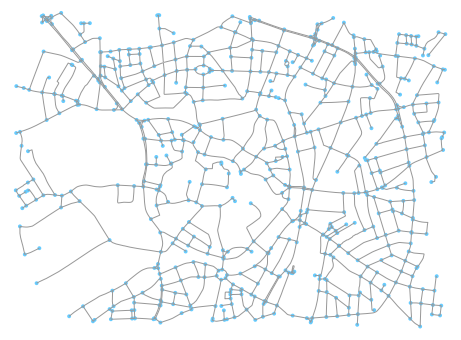

(<Figure size 576.497x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e4776655c8>)

In [243]:
import osmnx as ox

G = ox.graph_from_bbox(51.974045, 51.952343, 7.65083, 7.603312, network_type='drive')
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

## Convert the OSM Netwok to geodataframe and filter the attributes

In [260]:
nodes, streets = ox.graph_to_gdfs(G)
road_network = streets[['maxspeed','length','surface']]
road_network
#to check the type of surface "for rolling coff."
for i in road_network.index:
    if road_network.loc[i, 'surface'] == "asphalt":
        road_network.loc[i, 'rolling_resistance'] = 0.02 # source: engineeringtoolbox.com
    elif road_network.loc[i, 'surface'] == "cobblestone":
        road_network.loc[i, 'rolling_resistance'] = 0.015 # source: engineeringtoolbox.com
    elif road_network.loc[i, 'surface'] == "paving_stones":
        road_network.loc[i, 'rolling_resistance'] = 0.033 # source: The Automotive Chassis book
    else:
        road_network.loc[i, 'rolling_resistance'] = 0.02
        
road_network

,maxspeed,length,surface,rolling_resistance
0,50,6.146,asphalt,0.02
1,50,200.247,asphalt,0.02
2,30,12.933,asphalt,0.02
3,50,96.147,asphalt,0.02
4,NaN,119.161,asphalt,0.02
...,...,...,...,...
915,30,68.594,asphalt,0.02
916,30,56.319,asphalt,0.02
917,NaN,56.935,NaN,0.02
918,30,81.071,asphalt,0.02
